In [13]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
from functools import partial
import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [10]:
class Gaussian:
    def __init__(self, mean, cov, key=None):
        self.mean = mean
        self.cov = cov
        self.invcov = jnp.linalg.inv(cov)
        self.detcov = jnp.linalg.det(cov)
        self.dim = len(mean)
        if key is not None:
            self.key = key
        else:
            self.key = jax.random.PRNGKey(time.time_ns())
        if self.cov.shape != (self.dim, self.dim):
            raise ValueError("Covariance matrix must be square and match the dimension of the mean vector.")

    
    def _sample(self, n_samples, key):
        key, rng_key = jax.random.split(key)
        samples = jax.random.multivariate_normal(rng_key, self.mean, self.cov, shape=(n_samples,))
        return key, samples
    
    def sample(self, n_samples):
        self.key, samples = self._sample(n_samples, self.key)
        return samples

    @partial(jax.jit, static_argnums=(0,))
    def _log_prob(self, x):
        diff = x - self.mean
        exponent = -0.5 * jnp.dot(diff.T, jnp.matmul(self.invcov, diff))
        variance_term = -0.5 * (self.dim * jnp.log(2 * jnp.pi) + jnp.log(self.detcov))
        return variance_term + exponent
    
    def log_prob(self, x):
        if x.shape[0] != self.dim:
            return jax.vmap(self._log_prob)(x)
        else:
            return self._log_prob(x)

In [11]:
def compute_KL(base, comparison, tol=3e-2, n_samples=10000, init_steps=3):
    KL_vals = []
    num_steps = 0
    for _ in range(init_steps):
        samples = base.sample(n_samples)
        KL_estimate = jnp.mean(base.log_prob(samples) - comparison.log_prob(samples))
        KL_vals.append(KL_estimate)
        num_steps += 1
    while jnp.std(jnp.array(KL_vals)) / jnp.sqrt(num_steps) > tol * jnp.mean(jnp.array(KL_vals)):
        samples = base.sample(n_samples)
        KL_estimate = jnp.mean(base.log_prob(samples) - comparison.log_prob(samples))
        KL_vals.append(KL_estimate)
        num_steps += 1
    return jnp.mean(jnp.array(KL_vals)), jnp.std(jnp.array(KL_vals)) / jnp.sqrt(num_steps)

In [12]:
dim = 1
posterior_1 = Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim))
posterior_2 = Gaussian(mean=jnp.array([0.1]), cov=jnp.eye(dim))

In [5]:
kl_samples = []
for _ in tqdm.tqdm(range(1000)):
    kl, delta_kl = compute_KL(posterior_1, posterior_2, tol=1e-2, n_samples=10000, init_steps=3)
    kl_samples.append(kl)
kl_samples = jnp.array(kl_samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [01:24<?, ?it/s]


KeyboardInterrupt: 

In [16]:
dim = 10
posterior_base = Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim))
sigmas = jnp.geomspace(1e-1, 1.0, 50)
kl_vals = []
dkl_vals = []

for sigma in tqdm.tqdm(np.array(sigmas)):
    mean_array = np.ones(dim) * sigma
    mean_array[0] = sigma
    posterior_compare = Gaussian(mean=jnp.array(mean_array), cov=jnp.eye(dim))
    kl, delta_kl = compute_KL(posterior_base, posterior_compare, tol=1e-2, n_samples=100000, init_steps=3)
    kl_vals.append(kl)
    dkl_vals.append(delta_kl)
kl_vals = jnp.array(kl_vals)
dkl_vals = jnp.array(dkl_vals)

100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Text(0, 0.5, '$D_{KL}$')

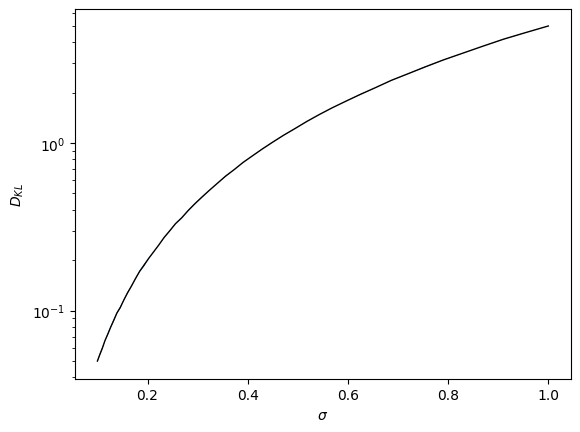

In [17]:
plt.semilogy(sigmas, kl_vals, label="KL Divergence", c='k', zorder=10, linewidth=1.0)
plt.fill_between(sigmas, kl_vals - 2 * dkl_vals, kl_vals + 2 * dkl_vals, alpha=1.0)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$D_{KL}$")

Text(0, 0.5, '$D_{KL}$')

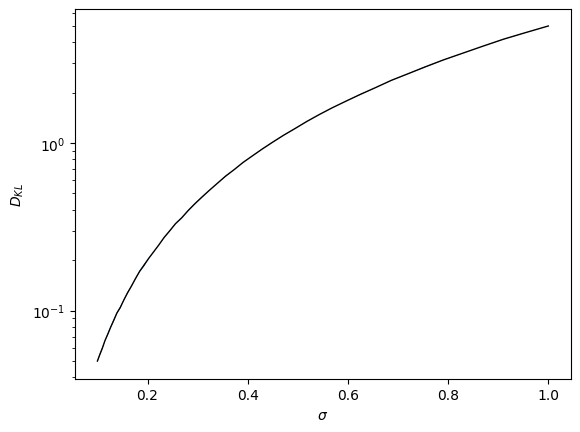

In [18]:
plt.semilogy(sigmas, kl_vals, label="KL Divergence", c='k', zorder=10, linewidth=1.0)
plt.fill_between(sigmas, kl_vals - 2 * dkl_vals, kl_vals + 2 * dkl_vals, alpha=1.0)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$D_{KL}$")

Text(0, 0.5, '$D_{KL}$')

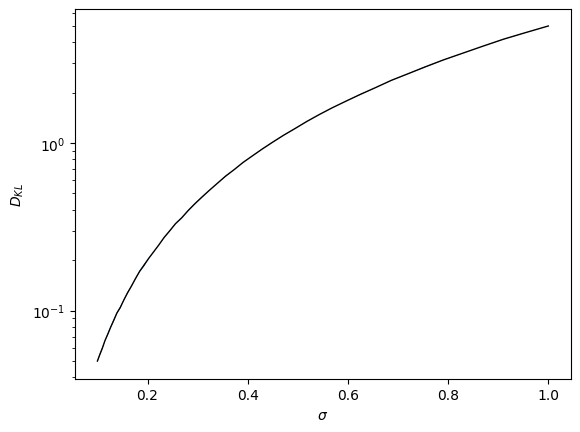

In [19]:
plt.semilogy(sigmas, kl_vals, label="KL Divergence", c='k', zorder=10, linewidth=1.0)
plt.fill_between(sigmas, kl_vals - 2 * dkl_vals, kl_vals + 2 * dkl_vals, alpha=1.0)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$D_{KL}$")

In [41]:
dim = 10
posterior_base = Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim))
sigmas = jnp.geomspace(.5, 2, 50)
kl_vals = []
dkl_vals = []

for sigma in tqdm.tqdm(np.array(sigmas)):
    mean_array = np.ones(dim) * sigma
    mean_array[0] = sigma
    posterior_compare = Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim) * sigma**2)
    kl, delta_kl = compute_KL(posterior_base, posterior_compare, tol=1e-2, n_samples=100000, init_steps=3)
    kl_vals.append(kl)
    dkl_vals.append(delta_kl)
    
kl_vals = jnp.array(kl_vals)
dkl_vals = jnp.array(dkl_vals)

100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Text(0, 0.5, '$D_{KL}$')

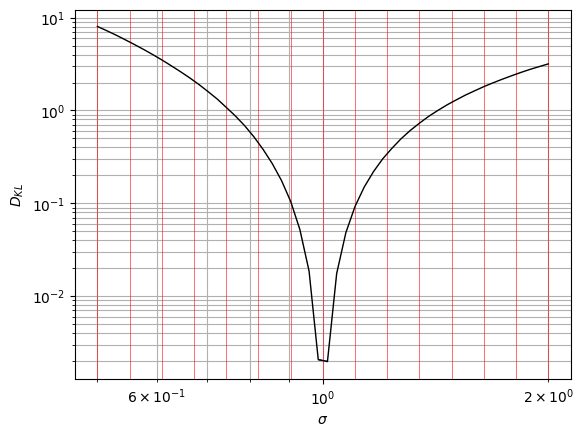

In [63]:
plt.loglog(sigmas, kl_vals, label="KL Divergence", c='k', zorder=10, linewidth=1.0)
plt.fill_between(sigmas, kl_vals - 2 * dkl_vals, kl_vals + 2 * dkl_vals, alpha=1.0)

plt.grid(which='both')


for y in jnp.geomspace(.5, 2, 15):
    plt.axvline(y, c='red', alpha=0.8, linewidth=0.5)

plt.xlabel(r"$\sigma$")
plt.ylabel(r"$D_{KL}$")

In [64]:
 jnp.geomspace(.5, 2, 15)

Array([0.5       , 0.55204476, 0.60950683, 0.6729501 , 0.74299714,
       0.82033536, 0.90572366, 1.        , 1.10408951, 1.21901365,
       1.34590019, 1.48599429, 1.64067071, 1.81144733, 2.        ],      dtype=float64)

In [20]:
import corner

KL ~ 1/2 sigma^2 dim 
sqrt(KL * 2 / dim) ~ (Delta sigma / sigma)

In [21]:
samples_1 = posterior_base.sample(10000)
samples_2 = posterior_compare.sample(10000)

5it [00:01,  4.31it/s]


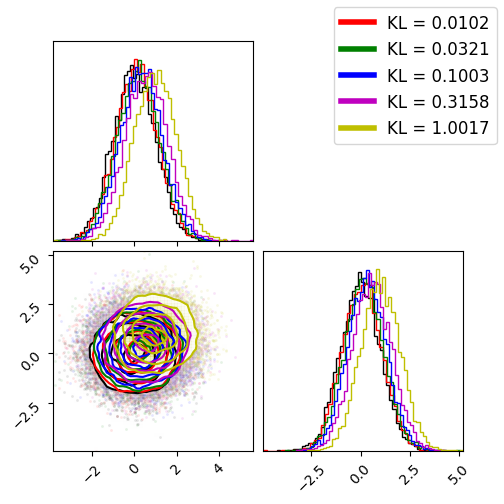

In [22]:
dim = 2
posterior_base = Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim))
sigmas = jnp.geomspace(1e-1, 1.0, 5)
kl_vals = []
dkl_vals = []
colors = ['r', 'g', 'b', 'm', 'y']

samples_base = posterior_base.sample(10000)
fig = corner.corner(np.array(samples_base), hist_kwargs={'density': True}, bins=50, color='k', smooth=1.0);

handles = []
for sigma, col in tqdm.tqdm(zip(sigmas, colors)):
    mean_array = np.ones(dim) * sigma
    posterior_compare = Gaussian(mean=jnp.array(mean_array), cov=jnp.eye(dim))
    kl, delta_kl = compute_KL(posterior_base, posterior_compare, tol=1e-2, n_samples=100000, init_steps=3)
    kl_vals.append(kl)
    dkl_vals.append(delta_kl)
    samples_compare = posterior_compare.sample(10000)
    corner.corner(np.array(samples_compare), hist_kwargs={'density': True}, bins=50, fig=plt.gcf(), color=col, smooth=1.0, hist2d_kwargs={'plot_datapoints': False});
    handles.append(plt.Line2D([0], [0], color=col, lw=4, label=f"KL = {kl:.4f}"))

fig.legend(handles=handles, loc="upper right", fontsize=12)

kl_vals = jnp.array(kl_vals)
dkl_vals = jnp.array(dkl_vals)
plt.show()

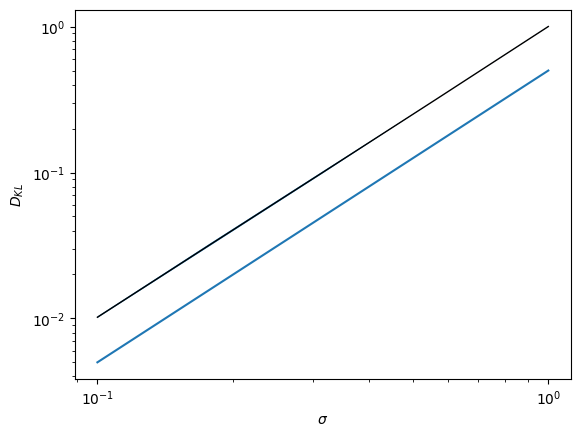

In [23]:
plt.loglog(sigmas, kl_vals, label="KL Divergence", c='k', zorder=10, linewidth=1.0)
plt.fill_between(sigmas, kl_vals - 2 * dkl_vals, kl_vals + 2 * dkl_vals, alpha=1.0)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$D_{KL}$")
plt.plot(sigmas, 0.5 * sigmas**2)

In [24]:
def compute_KL_GM(base, comparison, tol=3e-2, n_samples=10000, init_steps=3):
    KL_vals = []
    num_steps = 0
    for _ in range(init_steps):
        samples_one = base[0].sample(n_samples)
        samples_two = base[1].sample(n_samples)
        samples = jnp.concatenate((samples_one, samples_two), axis=0)
        base_log_prob_one = base[0].log_prob(samples)
        base_log_prob_two = base[1].log_prob(samples)
        base_log_prob = jnp.log((jnp.exp(base_log_prob_one) + jnp.exp(base_log_prob_two)) / 2)
        comparison_log_prob_one = comparison[0].log_prob(samples)
        comparison_log_prob_two = comparison[1].log_prob(samples)
        comparison_log_prob = jnp.log((jnp.exp(comparison_log_prob_one) + jnp.exp(comparison_log_prob_two)) / 2)
        KL_estimate = jnp.mean(base_log_prob - comparison_log_prob)
        KL_vals.append(KL_estimate)
        num_steps += 1
    while jnp.std(jnp.array(KL_vals)) / jnp.sqrt(num_steps) > tol * jnp.mean(jnp.array(KL_vals)):
        samples_one = base[0].sample(n_samples)
        samples_two = base[1].sample(n_samples)
        samples = jnp.concatenate((samples_one, samples_two), axis=0)
        base_log_prob_one = base[0].log_prob(samples)
        base_log_prob_two = base[1].log_prob(samples)
        base_log_prob = jnp.log((jnp.exp(base_log_prob_one) + jnp.exp(base_log_prob_two)) / 2)
        comparison_log_prob_one = comparison[0].log_prob(samples)
        comparison_log_prob_two = comparison[1].log_prob(samples)
        comparison_log_prob = jnp.log((jnp.exp(comparison_log_prob_one) + jnp.exp(comparison_log_prob_two)) / 2)
        KL_estimate = jnp.mean(base_log_prob - comparison_log_prob)
        KL_vals.append(KL_estimate)
        num_steps += 1
    return jnp.mean(jnp.array(KL_vals)), jnp.std(jnp.array(KL_vals)) / jnp.sqrt(num_steps)

In [25]:
dim = 3
base = [Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim)), Gaussian(mean=10.* jnp.ones(dim), cov=jnp.eye(dim))]
comparison = [Gaussian(mean=0.1 * jnp.ones(dim), cov=jnp.eye(dim)), Gaussian(mean=10.1 * jnp.ones(dim), cov=jnp.eye(dim))]

In [26]:
compute_KL_GM(base, comparison, tol=1e-2, n_samples=10000, init_steps=3)

(Array(0.01474653, dtype=float64), Array(0.00014643, dtype=float64))

In [27]:
compute_KL(Gaussian(mean=jnp.zeros(dim), cov=jnp.eye(dim)), 
           Gaussian(mean=0.1 * jnp.ones(dim), cov=jnp.eye(dim)), 
           tol=1e-2, n_samples=10000, init_steps=3)

(Array(0.01508412, dtype=float64), Array(0.0001505, dtype=float64))

In [28]:
samples_one = base[0].sample(1000)
samples_two = base[1].sample(1000)
samples = jnp.concatenate((samples_one, samples_two), axis=0)
base_log_prob_one = base[0].log_prob(samples)
base_log_prob_two = base[1].log_prob(samples)
comparison_log_prob_one = comparison[0].log_prob(samples)
comparison_log_prob_two = comparison[1].log_prob(samples)

In [29]:
base_log_prob_two

Array([-136.6115467 , -166.50966787, -145.28339838, ...,   -3.03812388,
         -3.03654895,   -3.47757766], dtype=float64)

ValueError: x and y must be the same size

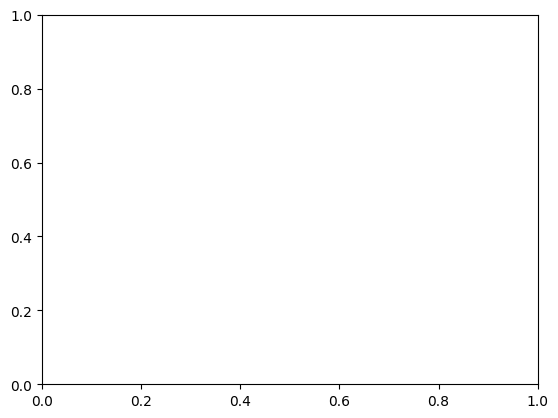

In [30]:
plt.scatter(samples, jnp.log((jnp.exp(base_log_prob_one) + jnp.exp(base_log_prob_two)) / 2))
#plt.scatter(samples, jnp.exp(base_log_prob_two))